# Portfolio Optimization Using Monte Carlo Simulation & Scipy Optimization



In [1]:
# Import packages
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
!pip install yfinance
import yfinance as yf
from pprint import pprint
from sklearn.preprocessing import StandardScaler

# Set some display options for Pandas.
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

     |████████████████████████████████| 6.3 MB 8.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=53aa55b01bc453e36d11048bdae7d25f4d8ad24c765fc89874cadd8505daa36c
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [2]:
# Define the symbols
# At different points, we will need to generate metrics based on the number
# of symbols we have, so let's save some time and just calculate that now.
# Read and print the stock tickers 


# Get the data for this tickers from yahoo finance

tickers=["XOM","BAC","IBM","PFE","TSLA"]
#tickers=["XOM"]
number_of_symbols = len(tickers)
Stocks_hist=yf.download(tickers,interval='1d',start='2015-01-01',end='2020-12-31', auto_adjust=True, group_by='ticker',index=False)
Stocks_hist = Stocks_hist.stack(level=0).rename_axis(['Date', 'Symbols']).reset_index(level=1)
Stocks_hist.to_csv('stock_data.csv')
price_data_frame = pd.read_csv('stock_data.csv',delimiter=',')
print('Loaded data from the Stocks repository')

# Print the head.
print(price_data_frame.head())


[*********************100%***********************]  5 of 5 completed
Loaded data from the Stocks repository
         Date Symbols       Close        High         Low        Open    Volume
0  2015-01-02  BAC     15.880880   15.996217   15.685697   15.960728   48951100
1  2015-01-02  IBM     121.796097  122.735534  120.999456  121.232435  5525500 
2  2015-01-02  PFE     23.154585   23.487159   23.073289   23.110243   16371571
3  2015-01-02  TSLA    43.862000   44.650002   42.652000   44.574001   23822000
4  2015-01-02  XOM     67.654991   67.815329   66.911607   67.232283   10220400


In [3]:
# Since we don't need all the data, let's limit the columns we need to work with.
price_data_frame = price_data_frame[['Date', 'Symbols', 'Close']]

# Once we've done that, use the `pivot` method to reorganize the data. Have the `date`
# be our new index, the `symbols` as our columns, and the `close` price as our values.
price_data_frame = price_data_frame.pivot(
    index='Date',
    columns='Symbols',
    values='Close'
)
print(price_data_frame.head())

Symbols           BAC         IBM        PFE       TSLA        XOM
Date                                                              
2015-01-02  15.880880  121.796097  23.154585  43.862000  67.654991
2015-01-05  15.419531  119.879631  23.028952  42.018002  65.803818
2015-01-06  14.958190  117.294296  23.221106  42.256001  65.453995
2015-01-07  15.029169  116.527733  23.538900  42.189999  66.117226
2015-01-08  15.339688  119.060432  24.019285  42.124001  67.217697


In [4]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.111310        0.036819         
1  0.347064        0.114801         
2  0.891767        0.294978         
3  0.759139        0.251108         
4  0.913884        0.302294         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.113799                    0.235174                       0.483892              
--------------------------------------------------------------------------------


# Monte Carlo Simulation



In [ ]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                                           Portfolio Weights
0  0.144277  0.265991    0.542414      [0.055112395871061225, 0.25684125173465916, 0.11307900962025748, 0.33100519700350894, 0.24396214577051326]
1  0.060190  0.223788    0.268961      [0.2596198611992481, 0.21354195605397092, 0.21133446436347644, 0.0843111246904918, 0.23119259369281261]   
2  0.052024  0.202950    0.256337      [0.008918796879734788, 0.3223437688237205, 0.35591879346291666, 0.09822727937980022, 0.21459136145382782] 
3  0.080384  0.236594    0.339755      [0.2388013009545225, 0.37979250705227785, 0.07713843249036605, 0.14150755598624198, 0.16276020351659146]  
4  0.165803  0.252353    0.657029      [0.2970641224925857, 0.1717234511359086, 0.2499011706181263, 0.2583411244311121, 0.02297013132226728]     
----------------------

In [ ]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.30673                                                                                                   
Volatility           0.36249                                                                                                   
Sharpe Ratio         0.846175                                                                                                  
Portfolio Weights    [0.04602966339544331, 0.012993563568987088, 0.32180689031769905, 0.6066012301321904, 0.012568652585680188]
Name: 3899, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.0389096                                                                                                 
Volatility           0.196698                          

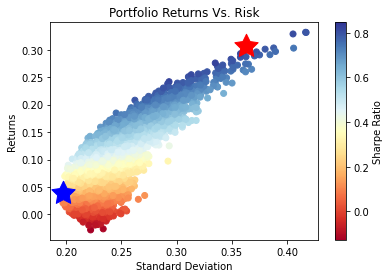

In [ ]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

# Scipy Optimization

Alright, there are multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.


In [5]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return - get_metrics(weights)[2]

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

Okay with our functions now defined, let's run the optimization using the `scipy.optimization` module. This module has a function called `minimize` which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a `fun`(function) that ensures we `equ`(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally distirbuted portofolio. In this case we have 5 symbols so each symbol will be 20% of the portfolio.

Once we've define this steps we can run the optimization by passing through the arguments defined and defining the `method` as `SLSQP` which is short for `Sequential Least Squares Programming`. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the `minimize` method we can grab the results.

The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the `fun` value. We can then take the `optimized_weights` defined by the `optimized_sharpe.x` values, and use them to return the different metrics we have for our portfolio.

In [6]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
     fun: -0.8557134672913682
     jac: array([ 1.34512782e-04,  2.13749655e-01,  1.24640763e-04, -7.00280070e-05,
        4.42517310e-01])
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.75805628e-03, 1.06034972e-16, 3.56834884e-01, 6.40407060e-01,
       0.00000000e+00])
--------------------------------------------------------------------------------


In [7]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[2.75805628e-03 1.06034972e-16 3.56834884e-01 6.40407060e-01
 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.32147882 0.37568513 0.85571347]
--------------------------------------------------------------------------------


In [8]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
     fun: 0.19564838878304916
     jac: array([0.21796714, 0.19578299, 0.19571049, 0.19458478, 0.19546073])
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([9.69739843e-19, 2.41263598e-01, 5.52676636e-01, 3.21086240e-02,
       1.73951143e-01])
--------------------------------------------------------------------------------


In [9]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[9.69739843e-19 2.41263598e-01 5.52676636e-01 3.21086240e-02
 1.73951143e-01]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.0386038  0.19564839 0.19731211]
--------------------------------------------------------------------------------
